<a href="https://www.kaggle.com/code/idanariav/customer-segmentation-project?scriptVersionId=250367104" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer segmentation (unsupervised learning project)
todo:
polish charts

This project uses the Online Retail II dataset from the UCI Machine Learning Repository, which contains transactional data from a UK-based e-commerce store that sells gifts and household goods.

The dataset includes:
* Customer invoices from 2010–2011
* quantities, and prices of purchased items
* Customer IDs (for repeat buyers)
* Country information (mostly UK-based, with some international orders)

Each row represents a single line item on an invoice per customer.

This rich transactional history enables us to explore unsupervised segmentation techniques based on customer-level and behavior.

## Set up

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_palette('viridis')
sns.set_style('whitegrid')

### Constants

In [2]:
SOURCE_FOLDER = '/kaggle/input'
DATASOURCE_FILENAME = 'ecommerce-data/data.csv'
RELEVANT_COLUMNS = ['InvoiceNo', 'Quantity', 'UnitPrice', 'InvoiceDate', 'CustomerID', 'Country']
FEATURES = ['Recency','Frequency','Monetary']
WEEKDAYS = {
    0: "monday",
    1: "tuesday",
    2: "wednesday",
    3: "thursday",
    4: "friday",
    5: "saturday",
    6: "sunday"
}

## Report

### Data cleaning

#### loading data and column creation

In [3]:
customer_purchases = pd.read_csv(os.path.join(SOURCE_FOLDER, DATASOURCE_FILENAME), usecols=RELEVANT_COLUMNS,
                  encoding='ISO-8859-1')
# turn column names into lower case
customer_purchases.columns = [col.lower() for col in customer_purchases.columns]

In [4]:
# change data types
customer_purchases['invoicedate'] = pd.to_datetime(customer_purchases['invoicedate'])
customer_purchases['unitprice'] = pd.to_numeric(customer_purchases['unitprice'], downcast='float')
customer_purchases['quantity'] = pd.to_numeric(customer_purchases['quantity'], downcast='integer')

In [5]:
# creating new columns
customer_purchases['invoice_date'] = customer_purchases['invoicedate'].dt.date
customer_purchases['invoice_time'] = customer_purchases['invoicedate'].dt.time
customer_purchases['invoice_day'] = customer_purchases['invoicedate'].dt.weekday
customer_purchases['weekday_name'] = customer_purchases['invoice_day'].map(WEEKDAYS)
customer_purchases = customer_purchases.drop(columns=['invoicedate', 'invoice_day'])
customer_purchases['invoice_spend'] = customer_purchases['unitprice'] * customer_purchases['quantity']

#### data cleaning
Reviewing the data, we noticed three main issues:
1. There are users without a user id
2. Most data comes from a single country
3. some invoices have a negative value

In general, the strategy would be:
1. Reomve users without id since we are interested in user level analysis
2. Remove non-uk orders since we don't have a reliable representation of customers from different markets (which we assume behave differently)
3. Solve cases of overcharging and same day returns/refunds, and remove all other cases

##### country level cleanup

In [6]:
count_by_country = customer_purchases['country'].value_counts()/len(customer_purchases)
count_by_country.head(10)

country
United Kingdom   0.914
Germany          0.018
France           0.016
EIRE             0.015
Spain            0.005
Netherlands      0.004
Belgium          0.004
Switzerland      0.004
Portugal         0.003
Australia        0.002
Name: count, dtype: float64

the vast majority (>90%) of the data comes from the  uk.
Since customers behave differently between states, we need to take the country as a feature. However since most data comes from the uk, our results will reflect data that is representative to the uk only. Therefore in order to improve our results, we should filter out non-uk transactions.

In [7]:
customer_purchases = customer_purchases[customer_purchases['country']=="United Kingdom"]
customer_purchases = customer_purchases.drop(columns=['country'])

##### id level cleanup

Regarding, the customer ids - roughtly 27% of purchases made by customers without an id.


In [8]:
customer_purchases['customerid'].isna().sum()/len(customer_purchases)

0.2696386116033406

Since we are interested in customer level analysis, we will remove them from the data

In [9]:
customer_purchases = customer_purchases.dropna(subset=["customerid"])
customer_purchases['customerid'] = pd.to_numeric(customer_purchases['customerid'], downcast='integer')

##### refunds cleanup

Invoices that start with the letter "C" have only negative quantities, which suggests a refund/return.
Based on the data, it seems that:
1. A refund can be partial (for example, I bought 8 things, and I'm returning 5)
2. A refund can take as long as 1 month (for example, I bought something in Novemeber, and I'm returning it 3 weeks after)
3. Refund invoice id has no connection to the original invoice number
4. some refunds represent a calculation error (such as overcharging) - these can be reomved by aggregating daily level purchases

In [10]:
# refunds are marked by invoices that starts with a letter (C)
refunds = customer_purchases[customer_purchases['invoiceno'].str.contains('[a-zA-Z]', na=False)]
refunds['invoice_spend'].describe()

count      7533.000
mean        -71.753
std        2191.612
min     -168469.600
25%         -16.950
50%          -8.250
75%          -3.300
max          -0.120
Name: invoice_spend, dtype: float64

In [11]:
# example of a partial refund (no single invoice has 5 items)
customer_purchases[(customer_purchases['customerid']==15311) & (customer_purchases['unitprice']==10.950000)].tail(10)

,invoiceno,quantity,unitprice,customerid,invoice_date,invoice_time,weekday_name,invoice_spend
21364,538076,8,10.950,15311,2010-12-09,14:15:00,thursday,87.600
28606,C538650,-1,10.950,15311,2010-12-13,15:05:00,monday,-10.950
44161,540157,8,10.950,15311,2011-01-05,11:41:00,wednesday,87.600
90692,544062,6,10.950,15311,2011-02-15,13:19:00,tuesday,65.700
432260,573865,8,10.950,15311,2011-11-01,12:00:00,tuesday,87.600
520453,580284,8,10.950,15311,2011-12-02,13:21:00,friday,87.600
530911,C580886,-5,10.950,15311,2011-12-06,12:25:00,tuesday,-54.750
531140,580904,8,10.950,15311,2011-12-06,12:59:00,tuesday,87.600
541715,C581568,-5,10.950,15311,2011-12-09,11:57:00,friday,-54.750
541744,581571,8,10.950,15311,2011-12-09,12:00:00,friday,87.600


In [12]:
# example of a delayed refund (see refund in 2011-12-09, and purchase in 2011-11-22)
customer_purchases[(customer_purchases['customerid']==17315) & (customer_purchases['unitprice']==1.25)].tail(10)

,invoiceno,quantity,unitprice,customerid,invoice_date,invoice_time,weekday_name,invoice_spend
320503,564976,4,1.250,17315,2011-08-31,15:49:00,wednesday,5.000
340334,566624,12,1.250,17315,2011-09-14,09:36:00,wednesday,15.000
415500,572541,2,1.250,17315,2011-10-24,16:20:00,monday,2.500
433318,573911,6,1.250,17315,2011-11-01,15:40:00,tuesday,7.500
433320,573911,16,1.250,17315,2011-11-01,15:40:00,tuesday,20.000
433321,573911,6,1.250,17315,2011-11-01,15:40:00,tuesday,7.500
488532,577833,6,1.250,17315,2011-11-22,10:20:00,tuesday,7.500
537796,581345,2,1.250,17315,2011-12-08,12:15:00,thursday,2.500
541716,C581569,-1,1.250,17315,2011-12-09,11:58:00,friday,-1.250
541717,C581569,-5,1.250,17315,2011-12-09,11:58:00,friday,-6.250


In [13]:
# example of refund due to overcharging
customer_purchases[customer_purchases['customerid']==16446]

,invoiceno,quantity,unitprice,customerid,invoice_date,invoice_time,weekday_name,invoice_spend
194354,553573,1,1.650,16446,2011-05-18,09:52:00,wednesday,1.650
194355,553573,1,1.250,16446,2011-05-18,09:52:00,wednesday,1.250
540421,581483,80995,2.080,16446,2011-12-09,09:15:00,friday,168469.600
540422,C581484,-80995,2.080,16446,2011-12-09,09:27:00,friday,-168469.600


Since we can't completly identity a refund and it's original purchase, we will create several summary charts
1. A daily level data - mostly for visitation analysis
2. A clean daily purchase data - based on the daily level, while removing refunds

#### creating summary tables
These tables will be used for the EDA and the modeling sections

In [14]:
# this is how the clean data looks like
customer_purchases

,invoiceno,quantity,unitprice,customerid,invoice_date,invoice_time,weekday_name,invoice_spend
0,536365,6,2.550,17850,2010-12-01,08:26:00,wednesday,15.300
1,536365,6,3.390,17850,2010-12-01,08:26:00,wednesday,20.340
2,536365,8,2.750,17850,2010-12-01,08:26:00,wednesday,22.000
3,536365,6,3.390,17850,2010-12-01,08:26:00,wednesday,20.340
4,536365,6,3.390,17850,2010-12-01,08:26:00,wednesday,20.340
...,...,...,...,...,...,...,...,...
541889,581585,12,1.950,15804,2011-12-09,12:31:00,friday,23.400
541890,581586,8,2.950,13113,2011-12-09,12:49:00,friday,23.600
541891,581586,24,1.250,13113,2011-12-09,12:49:00,friday,30.000
541892,581586,24,8.950,13113,2011-12-09,12:49:00,friday,214.800


In [15]:
# create total purchases per visit per client
customer_visit_summary = customer_purchases.groupby(['customerid', 'invoice_date', 'invoice_time', 'weekday_name']).agg({"invoice_spend": "sum"}).reset_index()

In [16]:
# daily level summary
customer_daily_summary = customer_purchases.groupby(['customerid', 'invoice_date', 'weekday_name']).agg({"invoice_spend": "sum"}).reset_index()

In [17]:
# daily clean summary
no_refunds = customer_daily_summary[customer_daily_summary['invoice_spend']>0]
customer_clean_daily_summary = no_refunds.groupby(['customerid', 'invoice_date', 'weekday_name']).agg({"invoice_spend": "sum"}).reset_index()

In [18]:
# customer level data
latest_sales_date = customer_purchases['invoice_date'].max() + timedelta(days=1)
customer_level_summary = (customer_clean_daily_summary.groupby(["customerid"])
         .agg(Recency=('invoice_date', lambda x: (latest_sales_date - x.max()).days),
              Frequency=('invoice_date', 'nunique'),
              Monetary=('invoice_spend', 'sum'))
      )

In [19]:
# purchases per day
daily_level_summary = no_refunds.groupby(['invoice_date', 'weekday_name']).agg({"invoice_spend": "sum", "customerid": "count"}).reset_index()

### EDA
Using the summary tables, we can explore it to examine the dataset's attributes and derive initial insights.

In [20]:
customer_clean_daily_summary['invoice_spend'].describe()

count   14971.000
mean      461.324
std      1071.592
min         0.000
25%       173.995
50%       307.140
75%       467.635
max     71601.440
Name: invoice_spend, dtype: float64

Text(0.5, 0, 'Amount (£)')

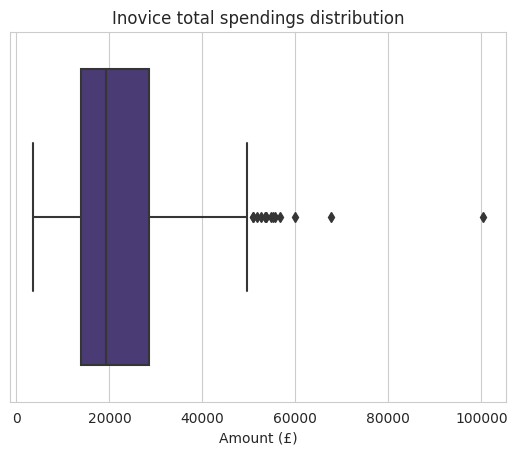

In [21]:
sns.boxplot(data=daily_level_summary, x='invoice_spend')
plt.title('Inovice total spendings distribution')
plt.xlabel('Amount (£)')

Text(0.5, 0, 'Number of visits')

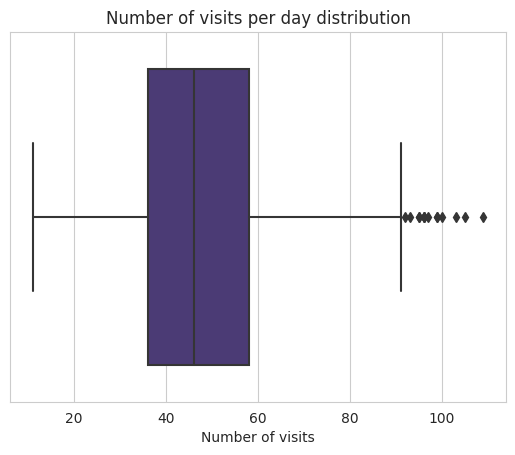

In [22]:
# most days have 40-60 customers (note that the number of visitors is probably higher)
sns.boxplot(data=daily_level_summary, x='customerid')
plt.title('Number of visits per day distribution')
plt.xlabel('Number of visits')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Amount (£)')

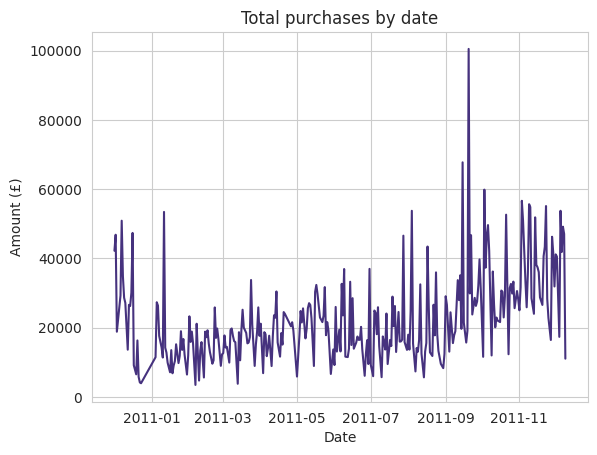

In [23]:
# sales follow a regular seasonality pattern.
# also we see a spike during christmas
sns.lineplot(data=daily_level_summary, x='invoice_date', y='invoice_spend')
plt.title('Total purchases by date')
plt.xlabel('Date')
plt.ylabel('Amount (£)')

Text(0.5, 0, '')

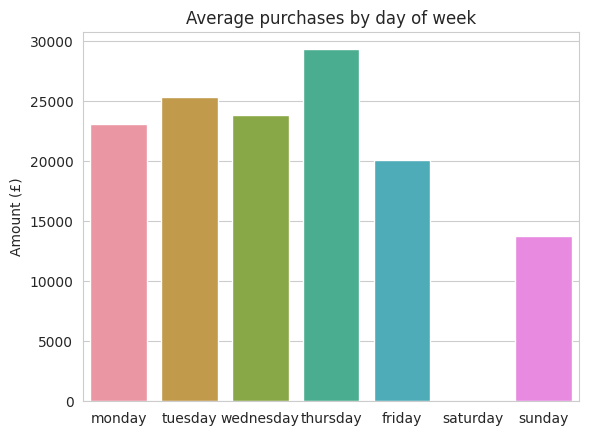

In [24]:
# sales are stable by day of week
# The website seems to be closed on saturday
sns.barplot(data=daily_level_summary, x='weekday_name', y='invoice_spend', errorbar=None, order=WEEKDAYS.values())
plt.title('Average purchases by day of week')
plt.ylabel('Amount (£)')
plt.xlabel('')

Text(0.5, 0, 'Amount (£)')

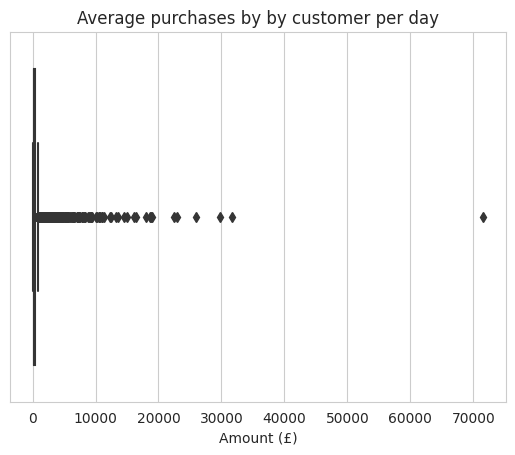

In [25]:
# most transactions are quite small, but there are some very large purchases
sns.boxplot(data=customer_clean_daily_summary, x='invoice_spend')
plt.title('Average purchases by by customer per day')
plt.xlabel('Amount (£)')

In [26]:
# Recency is how what percentage of customers have visited latley (under x days), 
# for example here we can see that 25% of customers have visited in the last 18 days
# Frequency are how many unique invoices (i.e how many purchases) are there per customer
# Monetary is the total spendings per customer
customer_level_summary.describe()

,Recency,Frequency,Monetary
count,3916.000,3916.000,3916.000
mean,92.843,3.823,1763.659
std,99.662,5.654,6694.545
min,1.000,1.000,2.900
25%,18.000,1.000,299.535
50%,51.000,2.000,643.965
75%,143.250,4.000,1556.600
max,374.000,112.000,256596.700


Text(0.5, 0, 'Number of visits')

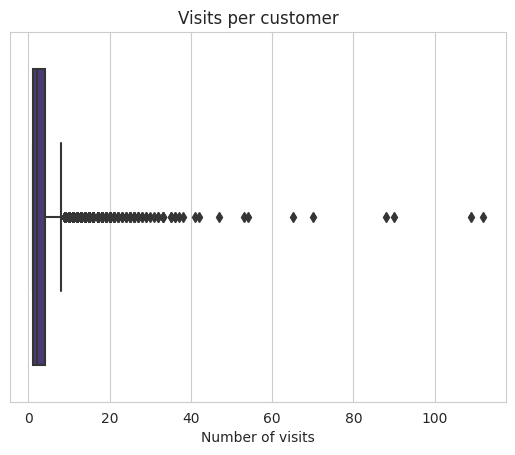

In [27]:
# most customers visits a handful of times, but some are frequent visitors
sns.boxplot(data=customer_level_summary, x='Frequency')
plt.title('Visits per customer')
plt.xlabel('Number of visits')

### Modeling

#### K means clustering model
The K means clustering model can help us detect how many different groups of customers are there based on the features we pass as inputs. 

First we use the "elbow method" to see which number of groups makes the most sense. As a general rule, more groups will always result in higher "matching" of customer behavior, but it is common practice to choose the value where the curve bends as the optimal number of groups without overfitting
For example, here we can see that either 4 or 5 can serve as optimal number of groups.
As a best practice, I will choose the smaller option of the two, i.e 4 groups

Using 4 clusters gives us a Silhouette score of 0.59, which counts as an overall good clustering

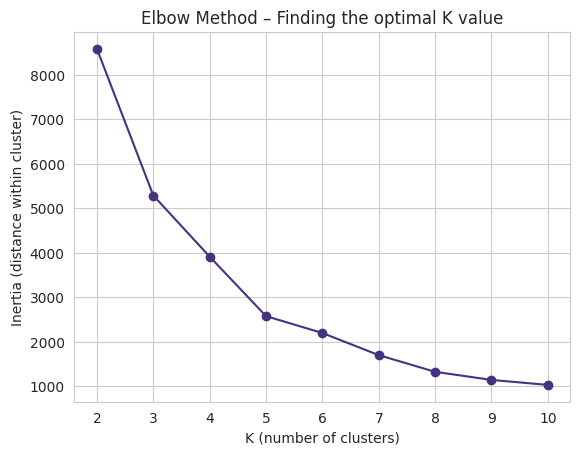

Silhouette score: 0.59472716421894


In [28]:
# prepare data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_level_summary[FEATURES])

# elbow method (inertia represents how tightly the data points are grouped around their assigned cluster centers)
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42,n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)



plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method – Finding the optimal K value')
plt.xlabel('K (number of clusters)')
plt.ylabel('Inertia (distance within cluster)')
plt.show()



# fit final model
k_opt = 4
km_final = KMeans(n_clusters=k_opt, random_state=42,n_init='auto')
customer_level_summary['KM_Cluster'] = km_final.fit_predict(X_scaled)
print('Silhouette score:', silhouette_score(X_scaled, customer_level_summary['KM_Cluster']))

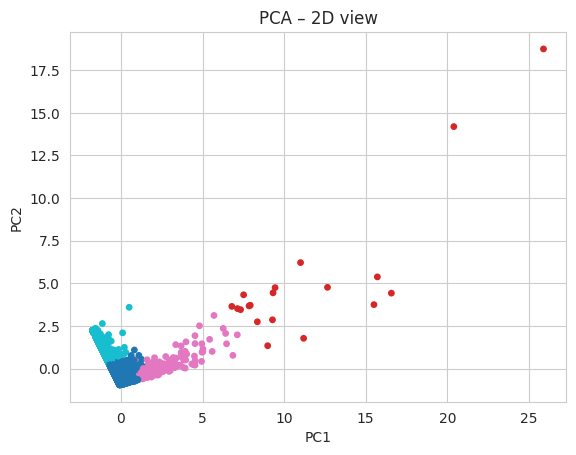

In [29]:

# A visuzlization of the 4 clusters by their components
pca = PCA(n_components=2).fit_transform(X_scaled)
plt.scatter(pca[:,0], pca[:,1], c=customer_level_summary['KM_Cluster'], s=15, cmap='tab10')
plt.xlabel('PC1'); 
plt.ylabel('PC2'); 
plt.title('PCA – 2D view');
plt.show()

In [30]:
# this chart helps us understand how what is the connection between each feature and it's component
# for example, pc1 is highly affected by frequent visits and high spendings
pca = PCA(n_components=2).fit(X_scaled)
feature_segmentation = pd.DataFrame(pca.components_.T, index=FEATURES, columns=['PC1', 'PC2'])
feature_segmentation

,PC1,PC2
Recency,-0.445,0.857
Frequency,0.664,0.121
Monetary,0.601,0.501


In [31]:
# This allows us to see the median values of each feature for every cluster
k_means_summary = (
    customer_level_summary.assign(Cluster=km.labels_)       
       .groupby('KM_Cluster')[FEATURES]
       .median()                          
       .round(1)
)

k_means_summary

,Recency,Frequency,Monetary
KM_Cluster,,,
0,34.000,3.000,748.500
1,4.000,33.000,55180.900
2,9.000,13.500,5396.400
3,243.000,1.000,305.500


conclusion

as we can see in the k_means_summary table, our customers can be divided into 4 groups, with the follwing attributes:
1. "one time clients" - customers who had relativly high spendings, came only a few times in recent periods
2. "loyal vips" - customers who visited in recent times, come often, and spend a lot
3. "loyal customers" - customers who visited in recent times, come often, and have slightly higher than average spendings
4. "past one timers" - visitors who came frequently yet not in recent period, and had low spendings

#### Gaussian Mixture Model
This model can help us measure how confident we should be that each cluster of visitors really display a different type of visitors, as compared to how much "fluid" the borders are between clusters

In [32]:
gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=0)
customer_level_summary["Prob_Max"] = gmm.fit(X_scaled).predict_proba(X_scaled).max(axis=1)  # confidence

customer_level_summary.groupby("KM_Cluster")[["Recency","Frequency","Monetary","Prob_Max"]].median()

,Recency,Frequency,Monetary,Prob_Max
KM_Cluster,,,,
0,34.000,3.000,748.500,0.926
1,4.000,33.000,55180.880,1.000
2,9.000,13.500,5396.380,0.992
3,243.000,1.000,305.515,0.997


conclusion

as we can see
all four clusters have a very high probability, which means that the distiction between different clusters, aka different customer behaviors is justified

## Summary

This project included the clean, analysis and modeling of an E-commerce dataset.
Using K means clustering as our main unsupervised learning model, we saw 4 distinct clusters based on different customer behaviors:
1. "one time clients" - customers who had relativly high spendings, came only a few times in recent periods
2. "loyal vips" - customers who visited in recent times, come often, and spend a lot
3. "loyal customers" - customers who visited in recent times, come often, and have slightly higher than average spendings
4. "past one timers" - visitors who came frequently yet not in recent period, and had low spendings

Analyzing current customer segmentation while constantly monitoring new customers' shopping patterns can help the business adjust their marketing and inventory strategies

A follow up analysis can include the types of products bought by each cluster.